# Imports

In [1]:
import os
import requests
import shutil
from pathlib import Path
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Data ImageFolder

In [3]:
train_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.RandomHorizontalFlip(p=0.5),
                                     transforms.ToTensor()])

test_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.ToTensor()])

In [4]:
data = datasets.ImageFolder(root="Melanoma Cancer Dataset/train")

In [5]:
img, label = data[0]

img.size, label

((224, 224), 0)

In [6]:
test_data = datasets.ImageFolder(root="Melanoma Cancer Dataset/test",
                                 transform=test_transform)

In [7]:
train_size = int(0.8 * len(data))
val_size = len(data) - train_size

train_data, val_data = random_split(data, [train_size, val_size])

In [8]:
train_data = datasets.ImageFolder(root="Melanoma Cancer Dataset/train",
                                 transform=train_transform)

val_data = datasets.ImageFolder(root="Melanoma Cancer Dataset/train",
                               transform=train_transform)

In [9]:
type(train_data), type(val_data), type(test_data)

(torchvision.datasets.folder.ImageFolder,
 torchvision.datasets.folder.ImageFolder,
 torchvision.datasets.folder.ImageFolder)

In [10]:
classes = train_data.classes
class_to_idx = train_data.class_to_idx

classes, class_to_idx

(['Benign', 'Malignant'], {'Benign': 0, 'Malignant': 1})

In [11]:
def plot_rand_imagefolder(dataset, n=3):
  fig, axes = plt.subplots(1, n, figsize=(10, 5))
  for i in range(n):
    idx = random.randint(0, len(dataset))
    img, label = dataset[idx]
    axes[i].imshow(img.permute(1, 2, 0))
    axes[i].set_title(dataset.classes[label])
    axes[i].axis('off')

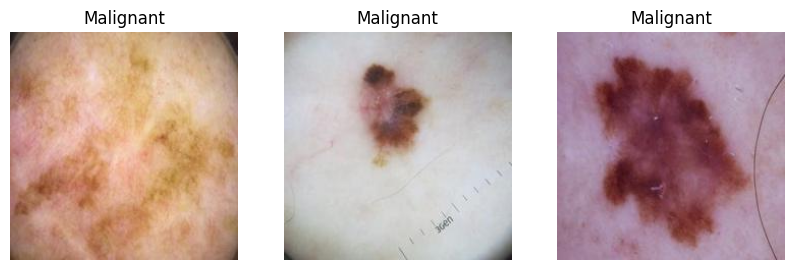

In [12]:
plot_rand_imagefolder(train_data)

# Image DataLoader

In [13]:
BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [14]:
img, label = next(iter(train_dataloader))

img.shape, label.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [15]:
def plot_rand_dataloader(dataset, n=3):
  fig, axes = plt.subplots(1, n, figsize=(10, 5))
  for i in range(n):
    idx = random.randint(0, len(dataset))
    img, label = next(iter(dataset))
    axes[i].imshow(img[i].permute(1, 2, 0))
    axes[i].set_title(classes[label[i]])
    axes[i].axis('off')

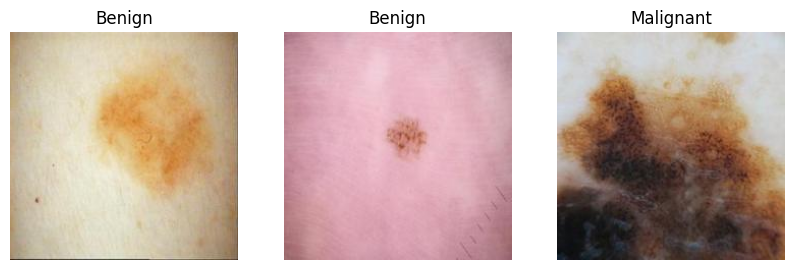

In [16]:
plot_rand_dataloader(train_dataloader)

# Model Experiment

## Model 0

### Model Building

In [17]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [18]:
class MelanomaCancerModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv_layer_1 = nn.Sequential(
      nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.conv_layer_2 = nn.Sequential(
      nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=64*56*56, out_features=128),
      nn.ReLU(),
      nn.Dropout(p=0.5),
      nn.Linear(in_features=128, out_features=2)
    )

  def forward(self, x):
    return self.classifier(self.conv_layer_2(self.conv_layer_1(x)))

In [19]:
torch.manual_seed(42)

model_0 = MelanomaCancerModelV0().to(device)
model_0

MelanomaCancerModelV0(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=200704, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [20]:
random_tensor = torch.randn(32, 3, 224, 224).to(device)

model_0(random_tensor).shape

torch.Size([32, 2])

### Model Training

#### Imports

In [21]:
request = requests.get("https://raw.githubusercontent.com/AaronGWang/MelanomaCancerClassification/main/helper_functions.py")
with open("helper_functions.py", "wb") as f:
  f.write(request.content)

In [22]:
from helper_functions import accuracy_fn, print_train_time, multiclass_train_loop, multiclass_validation_loop, eval_model
from tqdm.auto import tqdm
from timeit import default_timer as timer

In [23]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model_0.parameters(), lr=0.01)

In [24]:
epochs = 2
train_loss_list, train_acc_list = [], []
val_loss_list, val_acc_list = [], []

In [26]:
torch.manual_seed(42)

train_time_start_0 = timer()

for epoch in tqdm(range(epochs)):
  print(f"Epoch {epoch + 1}\n----------------")
  multiclass_train_loop(model=model_0,
                        train_dataloader=train_dataloader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        accuracy_fn=accuracy_fn,
                        train_loss_list=train_loss_list,
                        test_acc_list=train_acc_list,
                        device=device)
  
  